# **03. Modelling and Evaluation**

## Objectives

* Predict if a given cherry leaf is infected with powdery mildew or not.

## Inputs

* inputs/cherry_leaf_dataset/cherry-leaves/train
* inputs/cherry_leaf_dataset/cherry-leaves/validation
* inputs/cherry_leaf_dataset/cherry-leaves/test
* image shape embedding

## Outputs

* Images distribution plot in train, validation and test datasets.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Create, train and save a machine learning model.
* Learning curve plot for model performance.
* Model evaluation.
* Check model prediction.



## Additional Comments

* These modelling and evaluation steps will fulfil business requirement 2.




# Import Libraries

In [3]:
import os

In [4]:
import pandas as pd

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
import seaborn as sns

In [8]:
from matplotlib.image import imread

# Set Working Directory

In [9]:
cwd= os.getcwd()

In [10]:
os.chdir('/workspaces/Mildew_Detection_in_Cherry_Leaves')
print("You set a new current directory")

You set a new current directory


In [11]:
work_dir = os.getcwd()
work_dir

'/workspaces/Mildew_Detection_in_Cherry_Leaves'

Set input directories

In [12]:
my_data_dir = 'inputs/cherry_leaf_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Set output directory

In [13]:
version = 'v7'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


Set label names

In [14]:
labels = os.listdir(train_path)
print('The images labels are', labels)

The images labels are ['powdery_mildew', 'healthy']


Set image shape

In [15]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

# Image Distribution in Datasets

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




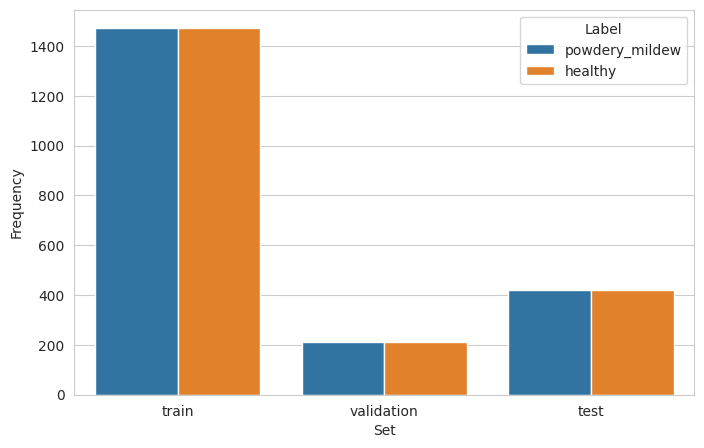

In [16]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

# Image Augmentation

As the dataset contains 4208 images, image augmentation will be used to create a larger image pool.

Import Libraries

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

Augment the training image dataset

In [19]:
batch_size = 20
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment the validation image dataset

In [20]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment the test image dataset

In [21]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot augmented training images

(20, 256, 256, 3)


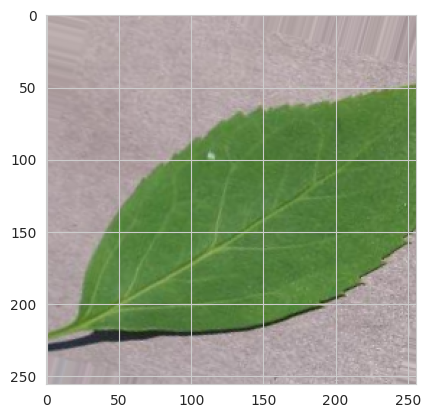

(20, 256, 256, 3)


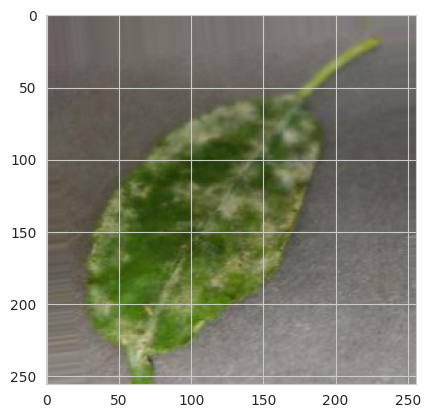

(20, 256, 256, 3)


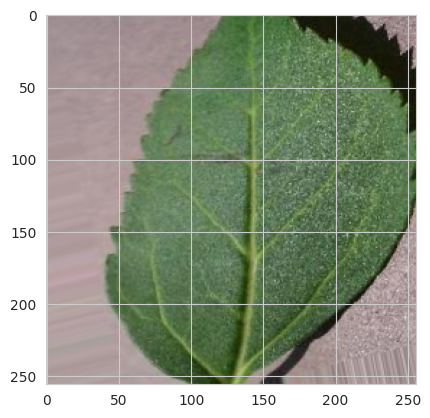

In [22]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Plot augmented validation images

(20, 256, 256, 3)


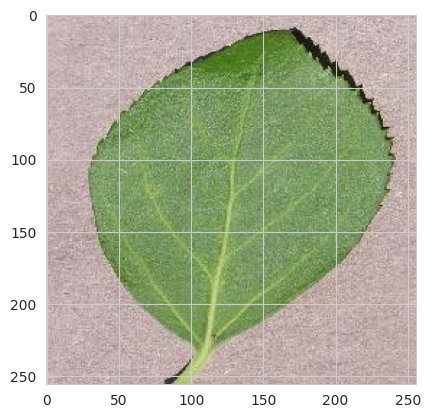

(20, 256, 256, 3)


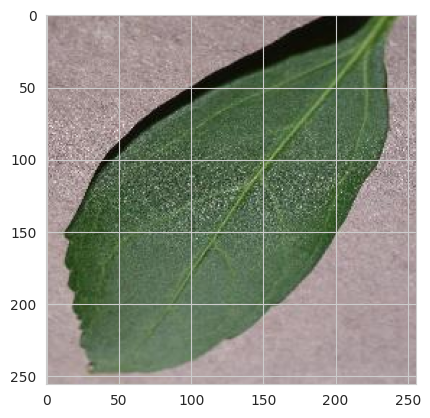

(20, 256, 256, 3)


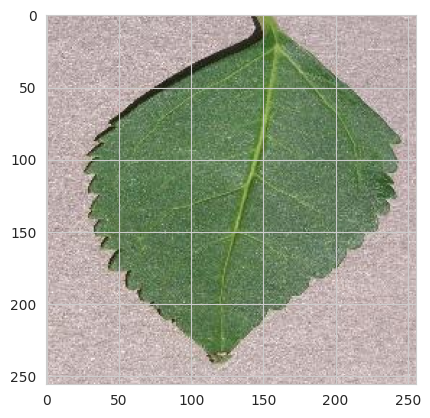

In [23]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Plot augmented test images

(20, 256, 256, 3)


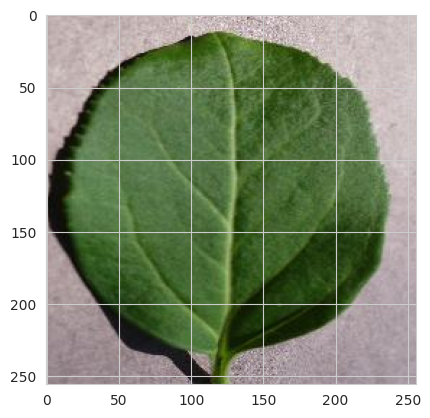

(20, 256, 256, 3)


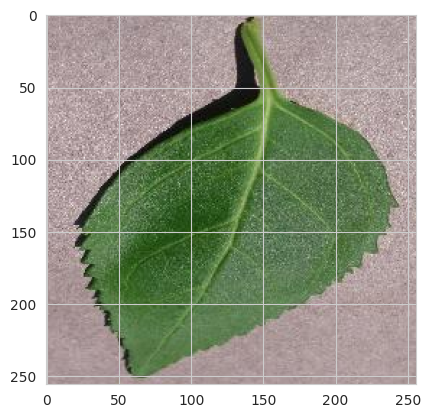

(20, 256, 256, 3)


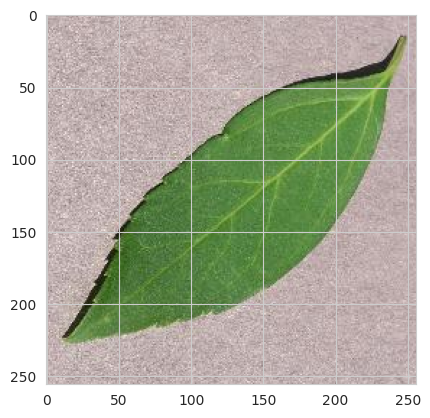

In [24]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Save class_indices

In [25]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v7/class_indices.pkl']

# Model Creation

Import Libraries

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Model

In [41]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))

    model.add(Dropout(0.3))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

Model Summary

In [42]:
create_tf_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 16)      4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14400)            

Early stopping

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

Fit model for model training

In [44]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
147/147 [==============================] - 239s 2s/step - loss: 0.3325 - accuracy: 0.8273 - val_loss: 0.0830 - val_accuracy: 0.9667
Epoch 2/25
147/147 [==============================] - 241s 2s/step - loss: 0.0845 - accuracy: 0.9720 - val_loss: 0.0116 - val_accuracy: 0.9976
Epoch 3/25
147/147 [==============================] - 242s 2s/step - loss: 0.0385 - accuracy: 0.9863 - val_loss: 0.0229 - val_accuracy: 0.9905
Epoch 4/25
147/147 [==============================] - 244s 2s/step - loss: 0.0416 - accuracy: 0.9853 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 5/25
147/147 [==============================] - 246s 2s/step - loss: 0.0170 - accuracy: 0.9945 - val_loss: 0.0387 - val_accuracy: 0.9929
Epoch 6/25
147/147 [==============================] - 243s 2s/step - loss: 0.0592 - accuracy: 0.9778 - val_loss: 0.0088 - val_accuracy: 0.9952
Epoch 7/25
147/147 [==============================] - 242s 2s/step - loss: 0.0245 - accuracy: 0.9911 - val_loss: 6.5001e-04 - val_accuracy: 1.

Save model

In [45]:
model.save('outputs/v7/mildew_detector_model.h5')

# Model Performance

## Model Learning Curve

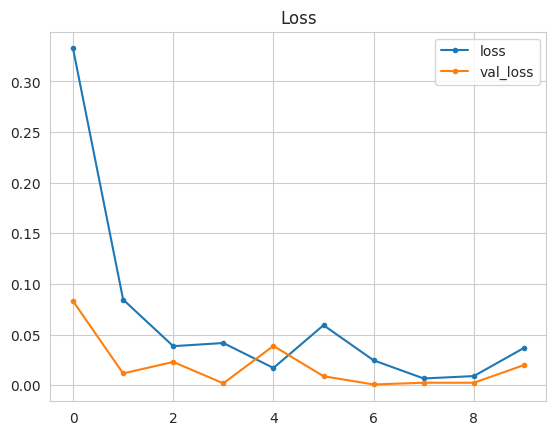

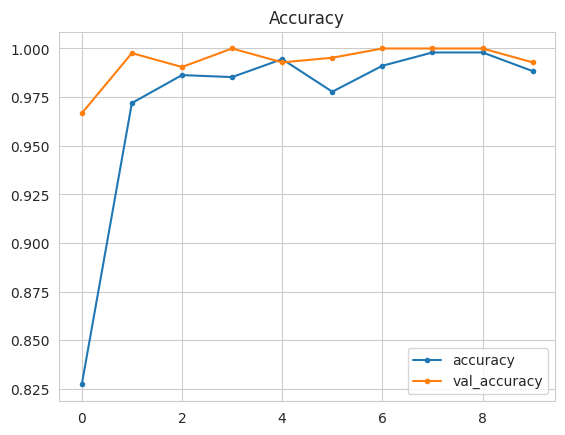

In [46]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Import Packages

In [47]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

Load saved model

In [48]:
from keras.models import load_model
model = load_model('outputs/v7/mildew_detector_model.h5')

Evaluate model on test set

In [49]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 17s 400ms/step - loss: 0.0035 - accuracy: 1.0000


Confusion Matrix

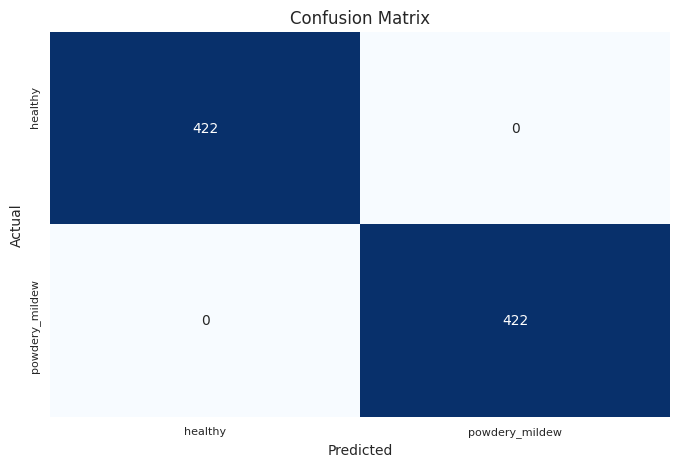

In [50]:
validation_set.reset()

x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels

cm = confusion_matrix(y_true,y_pred)

classes=list(test_set.class_indices.keys()) 
length=len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

Save evaluation

In [51]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v7/evaluation.pkl")

['outputs/v7/evaluation.pkl']

## Predict on New Data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


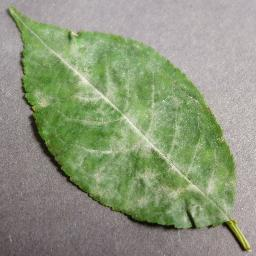

In [56]:
from tensorflow.keras.preprocessing import image

pointer = 60
label = labels[0]

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [57]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [58]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in {'Healthy': 1, 'Infected': 0}.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9866688707843423
Infected


# Conclusions and Next Steps

* Image augmentation was performed.
* Model was created and evaluated.
* As the validation and training plots follow a similar path, the data hasn't underfitted or overfitted.
* The model has exceeded the business requirement of 97% prediction accuracy.
* The model can accurately predict whether an image can be classified as healthy or containing powdery mildew.